In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn
from random import random 
from random import sample 
from scipy.stats import norm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.utils import class_weight
from sklearn import svm, datasets
import matplotlib 

matplotlib.rc('font', **{'size'   : 16})

In [2]:
DATA = "../preprocessing/standardized_data.csv"
data = pd.read_csv(DATA,header=0)

## Again, reusing the misclassification definitions

In [3]:
def gender_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been gender misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the ground truth or the result from the API is "unsure", no misclassification
        if gt[i] == 0 or prediction[i] == 0: 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [4]:
def race_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been race misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    for i in range(n): 
        # If the subjects is within a cornercase group or the prediction has outputed "not sure", then 
        # no misclassification
        if gt[i] in [0,5] or prediction[i] == 0 : 
            result[i] = 0
        # If the ground truth does not match the prediction, set the misclassification bit to one. 
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [5]:
def age_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been age misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        tolerance = 0 
        # If the subject is a child, tolerance interval equals 5
        if gt[i] <= 10: 
            tolerance = 5
        # For teenagers and pre-young-adults, tolerance is 10
        elif gt[i] <= 25: 
            tolerance = 10
        # For the rest of the population, tolerance is 15
        else: 
            tolerance = 15
            
        if gt[i] - tolerance <= prediction[i] <= gt[i] + tolerance: 
            result[i] = 0
        else: 
            result[i] = 1
    return result

In [6]:
def emotion_misclassification(gt, prediction): 
    """Given a vector of ground truth values `gt` and a vector of prediction values `gt`, 
    return a vector containing 1 if there has been emotion misclassification and 0 otherwise. """
    n = len(gt)
    assert(len(prediction) == n)
    result = np.zeros(n)
    
    for i in range(n): 
        # If dealing with one of the undefined emotions, set the misclassification bit to 0
        if gt[i] <= 0 or prediction[i] <= 0: 
            result[i] = 0 
        # If emotions don't match, set the misclassification bit to 1
        elif gt[i] != prediction[i]: 
            result[i] = 1
        else: 
            result[i] = 0
    return result

In [7]:
def recall(estimator, X, y): 
    """ Calculate the recall of the estimator predicting on inputs X with output labels y"""

    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
        
    tp = 0
    fn = 0
    
    for i in range(y.size): 
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue 
        if y[i] == 1 and prediction[i] == 0: 
            fn += 1
            
    return (tp / (tp + fn))

In [8]:
def precision(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = estimator.predict(X)
    
    y = np.array(y)
    prediction = np.array(prediction)
    tp = 0
    fp = 0
    for i in range(y.size):
        if y[i] == 1 and prediction[i] == 1:
            tp += 1
            continue
        if y[i] == 0 and prediction[i] == 1:
            fp += 1
    return (tp / (tp + fp))

In [9]:
def plot_scores(model, data=None, outputs=None): 
    """Given a classifier, display the cross-validation score on data (by default X_scaled) using 
    expected_cost, recall, precision and accuracy and scoring functions.""" 
    if data is None: 
        data = X_scaled
    if outputs is None: 
        outputs = y 
    recall_scores = cross_val_score(model, data, outputs, cv=5, scoring=recall)
    precision_scores = cross_val_score(model, data, outputs, cv=5, scoring=precision)
    accuracy_scores = cross_val_score(model, data, outputs, cv=5, scoring="accuracy")

    rec = sum(recall_scores)/10 
    prec = sum(precision_scores)/10
    acc = sum(accuracy_scores)/10
    
    df = pd.DataFrame((rec, prec, acc), index=["Recall", "Precision", "Accuracy"], columns=["Performance"])
    return df

# Gender Misclassification

In [10]:
data_no_ai = data[data["Origin"] != "AI"]
gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"])

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
cl = gender_misclassification(data_no_ai["Gender"], data_no_ai["clarifai_gender"]) == 1
ms = gender_misclassification(data_no_ai["Gender"], data_no_ai["microsoft_gender"]) == 1
am = gender_misclassification(data_no_ai["Gender"], data_no_ai["amazon_gender"]) == 1
fa = gender_misclassification(data_no_ai["Gender"], data_no_ai["face++_gender"]) == 1

In [12]:
gender_misclass = (cl | ms | am |fa)
sum(gender_misclass)

372

In [13]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in gender_misclass]

In [14]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [15]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
lr = LogisticRegression(solver='lbfgs') 

In [18]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8527139801123674

In [19]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [20]:
sum(prediction)

6

In [21]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [22]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.09615384615384616

In [23]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9968051118210862

In [24]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [25]:
lr = LogisticRegression(solver='lbfgs') 

In [26]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.5454154727793696

In [27]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

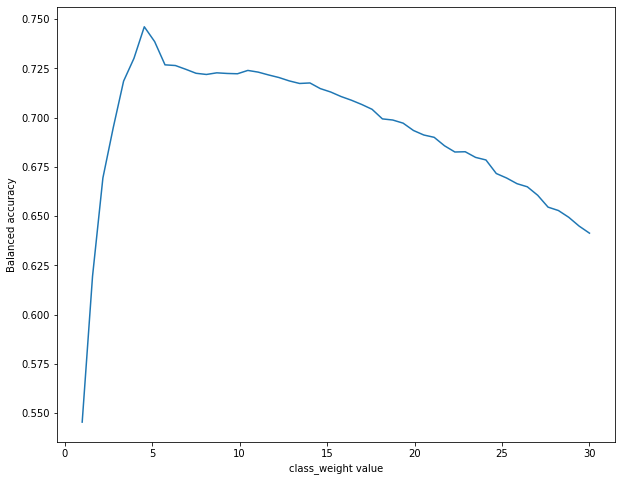

In [28]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [29]:
print(best_weight)
print(best_score)

4.551020408163265
0.7461491473997958


In [30]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7461491473997958

In [31]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [32]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.7692307692307692

Accuracy for the 0-class
0.6805111821086263

Balanced accuracy score: 
0.7248709756696977

Weighted accuracy
0.6931506849315068

Recall
0.7692307692307693

Precision
0.2857142857142857



In [33]:
print("We can see the most important factors for gender misclassification in out model are gender itself and age.")
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.37612911, -1.19335955,  0.15548981,  0.08650795, -0.10574491,
         0.02719346, -0.21064558, -0.86901431, -0.13521481, -0.60643437,
        -0.33188524, -0.25760684, -0.01642435, -0.19455391]])

In [34]:
lr_balanced.intercept_

array([-0.74834515])

In [35]:
T = X.copy()

In [36]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.3761291140948202),
 ('Gender', -1.193359545036913),
 ('is_black', 0.15548981098334427),
 ('is_white', 0.08650795233041393),
 ('is_asian', -0.10574490724707289),
 ('is_latino', 0.027193463604373296),
 ('is_rest', -0.21064557684205157),
 ('is_happy', -0.8690143110373493),
 ('is_sad', -0.13521480515425724),
 ('is_calm', -0.6064343747735529),
 ('is_angry', -0.33188523870985015),
 ('is_fearful', -0.25760684305286163),
 ('is_surprised', -0.016424348117757566),
 ('is_disgusted', -0.1945539126278514)]

# Race Misclassification 

In [37]:
data_no_ai = data[data["Origin"] != "AI"]

In [38]:
race_misclass = race_misclassification(data_no_ai["Race"], data_no_ai["clarifai_race"]) == 1
sum(race_misclass)

319

In [39]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in race_misclass]

In [40]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [41]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
lr = LogisticRegression(solver='lbfgs') 

In [44]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.8716166341474881

In [45]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [46]:
sum(prediction)

5

In [47]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [48]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.0196078431372549

In [49]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.9872611464968153

In [50]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [51]:
lr = LogisticRegression(solver='lbfgs') 

In [52]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.543880776635152

In [53]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

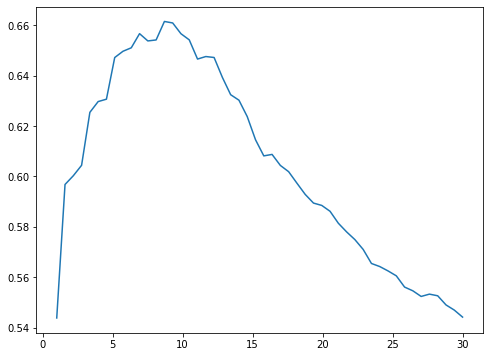

In [54]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,30,50), res)
plt.show()

In [55]:
print(best_weight)
print(best_score)

8.693877551020408
0.6614754228396684


In [56]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6614754228396684

In [57]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [58]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.803921568627451

Accuracy for the 0-class
0.4968152866242038

Balanced accuracy score: 
0.6503684276258275

Weighted accuracy
0.5397260273972603

Recall
0.803921568627451

Precision
0.20603015075376885



In [59]:
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.09462272,  0.11918919,  0.05955506,  0.56912835, -0.25130009,
         0.68700262, -0.16245511, -0.67028322, -0.31409301, -0.71445727,
        -0.30303207, -0.52904559, -0.36046121, -0.37546442]])

In [60]:
lr_balanced.intercept_

array([-0.0530811])

In [62]:
T = X.copy()

In [63]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.09462271694606161),
 ('Gender', 0.1191891937523505),
 ('is_black', 0.059555059820372604),
 ('is_white', 0.5691283469644901),
 ('is_asian', -0.25130008919504904),
 ('is_latino', 0.6870026175492537),
 ('is_rest', -0.1624551114264307),
 ('is_happy', -0.6702832183493889),
 ('is_sad', -0.3140930124752422),
 ('is_calm', -0.7144572677601029),
 ('is_angry', -0.30303207037274493),
 ('is_fearful', -0.5290455940892362),
 ('is_surprised', -0.3604612096034113),
 ('is_disgusted', -0.3754644212796123)]

# Age Misclassification Model  

In [64]:
data_no_ai = data[data["Origin"] != "AI"]

In [65]:
cl = age_misclassification(data["Age"], data["clarifai_age"]) == 1
ms = age_misclassification(data["Age"], data["microsoft_age"]) == 1
am = age_misclassification(data["Age"], data["amazon_age_average"]) == 1
fa = age_misclassification(data["Age"], data["face++_age"]) == 1

In [66]:
age_misclass = (cl | ms | am |fa)
sum(age_misclass)

1060

In [67]:
len(data)

2677

In [68]:
X = data[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in age_misclass]

In [69]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [70]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
lr = LogisticRegression(solver='lbfgs') 

In [73]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.680879120879121

In [74]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [76]:
is_actually_misclass = np.array(y_test) == 1
is_not_misclass = np.array(y_test) == 0

In [77]:
sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)

0.46540880503144655

In [78]:
sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)

0.8065843621399177

In [79]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [80]:
lr = LogisticRegression(solver='lbfgs') 

In [81]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6437148738667068

In [82]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,3,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

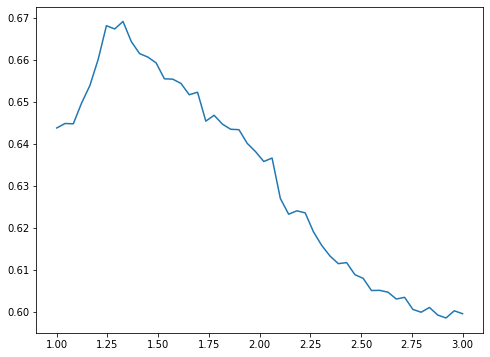

In [83]:
plt.figure(figsize=(8,6))
plt.plot(np.linspace(1,3,50), res)
plt.show()

In [84]:
print(best_weight)
print(best_score)

1.3265306122448979
0.6690770213731458


In [85]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.6690770213731458

In [86]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [87]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.5849056603773585

Accuracy for the 0-class
0.6790123456790124

Balanced accuracy score: 
0.6319590030281854

Weighted accuracy
0.6417910447761195

Recall
0.5849056603773585

Precision
0.543859649122807



In [88]:
lr_balanced.coef_

We can see the most important factors for gender misclassification in out model are gender itself and age.


array([[-0.49143633, -0.24242101,  0.22211327,  0.3307735 ,  0.05708781,
         0.16438131, -0.14388203, -0.09958229,  0.02485623, -0.5185121 ,
         0.04558632, -0.03456413, -0.2416753 ,  0.19971633]])

In [89]:
lr_balanced.intercept_

array([-0.21187702])

In [91]:
T = X.copy()

In [92]:
list(zip(X.columns, lr_balanced.coef_[0]))

[('Age', -0.4914363335761341),
 ('Gender', -0.2424210072841495),
 ('is_black', 0.22211327384620133),
 ('is_white', 0.3307735023486492),
 ('is_asian', 0.05708780720998713),
 ('is_latino', 0.16438130762432798),
 ('is_rest', -0.14388202839544456),
 ('is_happy', -0.09958229402854873),
 ('is_sad', 0.02485622604624165),
 ('is_calm', -0.5185121012903013),
 ('is_angry', 0.0455863204422589),
 ('is_fearful', -0.034564134024077695),
 ('is_surprised', -0.24167530091845657),
 ('is_disgusted', 0.19971633230810362)]

# Emotion Misclassification

In [93]:
data_no_ai = data[data["Origin"] != "AI"]

In [94]:
ms = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["microsoft_emotion"]) == 1
am = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["amazon_emotion"]) == 1
fa = emotion_misclassification(data_no_ai["Emotion"], data_no_ai["face++_emotion"]) == 1

In [95]:
emotion_misclass = (ms | am | fa)

In [96]:
X = data_no_ai[["Race", "Age", "Gender", "Emotion"]]
y = [int(x) for x in emotion_misclass]

In [97]:
# One-hot encoding
X_eng = X.copy()

is_black = [int(x) for x in X_eng["Race"] == 2]
is_white = [int(x) for x in X_eng["Race"] == 4]
is_asian = [int(x) for x in X_eng["Race"] == 1]
is_latino = [int(x) for x in X_eng["Race"] == 3]
is_rest = [int(x) for x in X_eng["Race"] == 5]

is_happy = [int(x) for x in X_eng["Emotion"] == 5]
is_sad = [int(x) for x in X_eng["Emotion"] == 6]
is_calm = [int(x) for x in X_eng["Emotion"] == 2]
is_angry = [int(x) for x in X_eng["Emotion"] == 1]
is_fearful = [int(x) for x in X_eng["Emotion"] == 4]
is_surprised = [int(x) for x in X_eng["Emotion"] == 7]
is_disgusted = [int(x) for x in X_eng["Emotion"] == 3]

X_eng["is_black"] = is_black
X_eng["is_white"] = is_white
X_eng["is_asian"] = is_asian
X_eng["is_latino"] = is_latino
X_eng["is_rest"] = is_rest
X_eng["is_happy"] = is_happy
X_eng["is_sad"] = is_sad
X_eng["is_calm"] = is_calm
X_eng["is_angry"] = is_angry
X_eng["is_fearful"] = is_fearful
X_eng["is_surprised"] = is_surprised
X_eng["is_disgusted"] = is_disgusted

X = X_eng.drop(columns=["Race", "Emotion"])

In [98]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [100]:
lr = LogisticRegression(solver='lbfgs') 

In [101]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5))/5

0.7688909001151883

In [102]:
lr.fit(X_train_scaled, y_train)
prediction = lr.predict(X_test_scaled)

In [103]:
def balanced_accuracy(estimator, X, y):
    """ Calculate the precision of the estimator predicting on inputs X with output labels y"""
    
    prediction = np.array(estimator.predict(X))
    y = np.array(y)
    
    is_actually_misclass = y == 1
    is_not_misclass = y == 0
    
    acc_for_1 = sum(prediction[is_actually_misclass] == 1)/sum(is_actually_misclass)
    acc_for_0 = sum(prediction[is_not_misclass] == 0)/sum(is_not_misclass)
    
    return (acc_for_0 + acc_for_1) / 2

In [104]:
lr = LogisticRegression(solver='lbfgs') 

In [105]:
sum(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7272889743911961

In [106]:
res = []
best_weight = None 
best_score = 0 
for w in np.linspace(1,30,50): 
    lr_tune = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:w})
    cv_score = sum(cross_val_score(lr_tune, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5
    if cv_score > best_score: 
        best_weight = w
        best_score = cv_score
    res.append(cv_score)

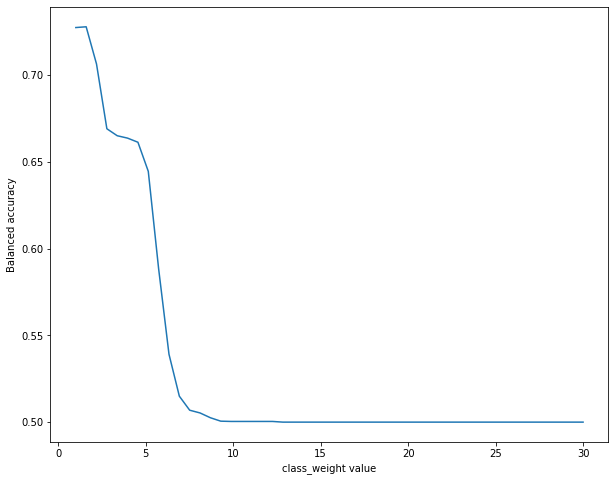

In [107]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1,30,50), res)
plt.xlabel("class_weight value")
plt.ylabel("Balanced accuracy")
#plt.savefig('training.svg', format='svg')
plt.show()

In [108]:
print(best_weight)
print(best_score)

1.5918367346938775
0.7277309783220381


In [109]:
lr_balanced = LogisticRegression(solver='lbfgs', class_weight={0:1, 1:best_weight}) 
sum(cross_val_score(lr_balanced, X_train_scaled, y_train, cv=5, scoring=balanced_accuracy))/5

0.7277309783220381

In [110]:
lr_balanced.fit(X_train_scaled, y_train)
balanced_prediction = lr_balanced.predict(X_test_scaled)

In [111]:
print("Accuracy for the 1-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 1] - 1))/sum(np.array(y_test) == 1))
print()
print("Accuracy for the 0-class")
print(1 - sum(abs(balanced_prediction[np.array(y_test) == 0] - 0))/sum(np.array(y_test) == 0))
print()
print("Balanced accuracy score: ")
print(balanced_accuracy(lr_balanced, X_test_scaled, y_test))
# Same as (acc_0 + acc_1)/2
print()
print("Weighted accuracy")
print(1 - sum(abs(balanced_prediction - y_test))/len(y_test))
print()
print("Recall")
print(recall(lr_balanced, X_test_scaled, y_test))
print()
print("Precision")
print(precision(lr_balanced, X_test_scaled, y_test))
print()

Accuracy for the 1-class
0.5966386554621849

Accuracy for the 0-class
0.8983739837398375

Balanced accuracy score: 
0.7475063196010111

Weighted accuracy
0.8

Recall
0.5966386554621849

Precision
0.7395833333333334

